In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

# T-Tail HALE Model tutorial

The HALE T-Tail model intends to be a representative example of a typical HALE configuration, with high flexibility and aspect-ratio.

A geometry outline and a summary of the beam properties are given next

In [2]:
url = 'https://raw.githubusercontent.com/ImperialCollegeLondon/sharpy/dev_doc/docs/source/content/example_notebooks/images/t-tail_geometry.png'
Image(url=url, width=800)

In [3]:
url = 'https://raw.githubusercontent.com/ImperialCollegeLondon/sharpy/dev_doc/docs/source/content/example_notebooks/images/t-tail_properties.png'
Image(url=url, width=500)

This case is included in `tests/coupled/simple_HALE/`. The `generate_hale.py` file in that folder is the one that, if executed, generates all the required SHARPy files. This document is a step by step guide to how to process that case.

The T-Tail HALE model is subject to a 20% 1-cos spanwise constant gust.

First, let's start with importing SHARPy in our Python environment.

In [4]:
import sharpy
import sharpy.sharpy_main as sharpy_main

And now the `generate_HALE.py` file needs to be executed.

In [5]:
route_to_case = '../../../../cases/coupled/simple_HALE/'
%run '../../../../cases/coupled/simple_HALE/generate_hale.py'

There should be 3 new files, apart from the original `generate_hale.py`:

In [6]:
!ls ../../../../cases/coupled/simple_HALE/

generate_hale.py  simple_HALE.aero.h5  simple_HALE.fem.h5  simple_HALE.sharpy


SHARPy can be run now. In the terminal, doing `cd` to the `simple_HALE` folder, the command would look like:
```
sharpy simple_HALE.sharpy
```

From a python console with `import sharpy` already run, the command is:

In [7]:
case_data = sharpy_main.main(['', route_to_case + 'simple_HALE.sharpy'])

/home/ad214/run/code_doc/sharpy/sharpy/aero/utils/uvlmlib.py:230: RuntimeWarning: invalid value encountered in true_divide
  flightconditions.uinf_direction = np.ctypeslib.as_ctypes(ts_info.u_ext[0][:, 0, 0]/flightconditions.uinf)
/home/ad214/run/code_doc/sharpy/sharpy/aero/utils/uvlmlib.py:347: RuntimeWarning: invalid value encountered in true_divide
  flightconditions.uinf_direction = np.ctypeslib.as_ctypes(ts_info.u_ext[0][:, 0, 0]/flightconditions.uinf)


The resulting data structure that is returned from the call to `main` contains all the time-dependant variables for both the structural and aerodynamic solvers.

`timestep_info` can be found in `case_data.structure` and `case_data.aero`. It is an array with custom-made structure to contain the data of each solver.

In the `.sharpy` file, we can see which solvers are run:
```
flow = ['BeamLoader',
        'AerogridLoader',
        'StaticTrim',
        'BeamLoads',
        'AerogridPlot',
        'BeamPlot',
        'DynamicCoupled',
        ]
```

In order:
* BeamLoader: reads the `fem.h5` file and generates the structure for the beam solver.
* AerogridLoader: reads the `aero.h5` file and generates the aerodynamic grid for the aerodynamic solver.
* StaticTrim: this solver performs a longitudinal trim (Thrust, Angle of attack and Elevator deflection) using the StaticCoupled solver.
* BeamLoads: calculates the internal beam loads for the static solution
* AerogridPlot: outputs the aerodynamic grid for the static solution.
* BeamPlot: outputs the structural discretisation for the static solution.
* DynamicCoupled: is the main driver of the dynamic simulation: executes the structural and aerodynamic solvers and couples both. Every converged time step is followed by a BeamLoads, AerogridPlot and BeamPlot execution.

### Structural data organisation

The `timestep_info` structure contains several relevant variables:
* `for_pos`: position of the body-attached frame of reference in inertial FoR.
* `for_vel`: velocity (in body FoR) of the body FoR wrt inertial FoR.
* `pos`: nodal position in A FoR.
* `psi`: nodal rotations (from the material B FoR to A FoR) in a Cartesian Rotation Vector parametrisation.
* `applied_steady_forces`: nodal forces from the aero solver and the applied forces.
* `postproc_cell`: is a dictionary that contains the variables generated by a postprocessor, such as the internal beam loads.

The structural `timestep_info` also contains some useful variables:
* `cag` and `cga` return $C^{AG}$ and $C^{GA}$, the rotation matrices from the body-attached (A) FoR to the inertial (G).
* `glob_pos` rotates the `pos` variable to give you the inertial nodal position. If `include_rbm = True` is passed, `for_pos` is added to it.

### Aerodynamic data organisation

The aerodynamic datastructure can be found in `case_data.aero.timestep_info`.
It contains useful variables, such as:
* `dimensions` and `dimensions_star`: gives the dimensions of every surface and wake surface. Organised as: `dimensions[i_surf, 0] = chordwise panels`, `dimensions[i_surf, 1] = spanwise panels`.
* `zeta` and `zeta_star`: they are the $G$ FoR coordinates of the surface vertices.
* `gamma` and `gamma_star`: vortex ring circulations.

### Structural dynamics

We can now plot the rigid body dynamics:

*RBM trajectory*

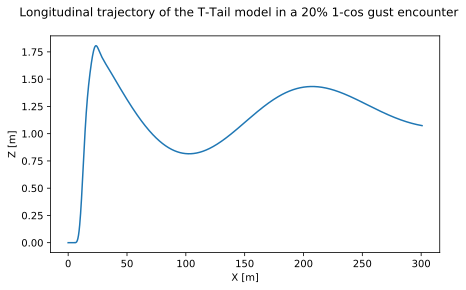

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(7, 4))

# extract information
n_tsteps = len(case_data.structure.timestep_info)
xz = np.zeros((n_tsteps, 2))
for it in range(n_tsteps):
    xz[it, 0] = -case_data.structure.timestep_info[it].for_pos[0] # the - is so that increasing time -> increasing x
    xz[it, 1] = case_data.structure.timestep_info[it].for_pos[2]
ax.plot(xz[:, 0], xz[:, 1])
fig.suptitle('Longitudinal trajectory of the T-Tail model in a 20% 1-cos gust encounter')
ax.set_xlabel('X [m]')
ax.set_ylabel('Z [m]');
plt.show()

*RBM velocities*

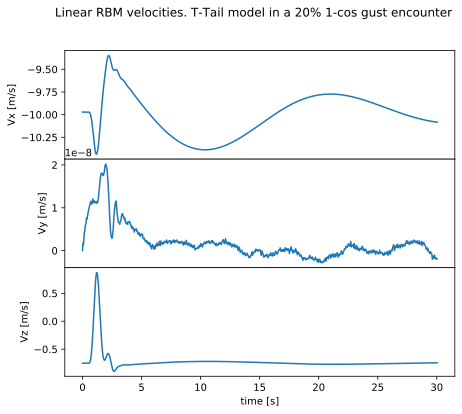

In [17]:
fig, ax = plt.subplots(3, 1, figsize=(7, 6), sharex=True)
ylabels = ['Vx [m/s]', 'Vy [m/s]', 'Vz [m/s]']

# extract information
n_tsteps = len(case_data.structure.timestep_info)
dt = case_data.settings['DynamicCoupled']['dt'].value
time_vec = np.linspace(0, n_tsteps*dt, n_tsteps)
for_vel = np.zeros((n_tsteps, 3))
for it in range(n_tsteps):
    for_vel[it, 0:3] = case_data.structure.timestep_info[it].for_vel[0:3]
    
for idim in range(3):
    ax[idim].plot(time_vec, for_vel[:, idim])
    ax[idim].set_ylabel(ylabels[idim])
    
ax[2].set_xlabel('time [s]')
plt.subplots_adjust(hspace=0)
fig.suptitle('Linear RBM velocities. T-Tail model in a 20% 1-cos gust encounter');
# ax.set_xlabel('X [m]')
# ax.set_ylabel('Z [m]');
plt.show()

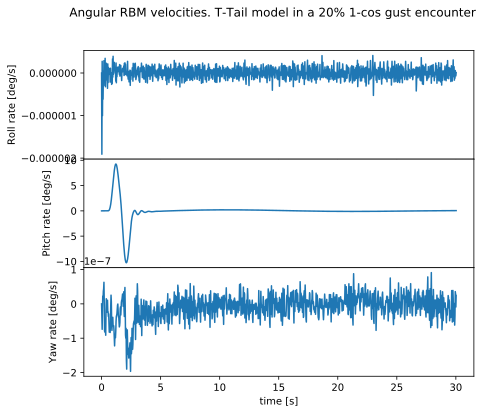

In [18]:
fig, ax = plt.subplots(3, 1, figsize=(7, 6), sharex=True)
ylabels = ['Roll rate [deg/s]', 'Pitch rate [deg/s]', 'Yaw rate [deg/s]']

# extract information
n_tsteps = len(case_data.structure.timestep_info)
dt = case_data.settings['DynamicCoupled']['dt'].value
time_vec = np.linspace(0, n_tsteps*dt, n_tsteps)
for_vel = np.zeros((n_tsteps, 3))
for it in range(n_tsteps):
    for_vel[it, 0:3] = case_data.structure.timestep_info[it].for_vel[3:6]*180/np.pi
    
for idim in range(3):
    ax[idim].plot(time_vec, for_vel[:, idim])
    ax[idim].set_ylabel(ylabels[idim])
    
ax[2].set_xlabel('time [s]')
plt.subplots_adjust(hspace=0)
fig.suptitle('Angular RBM velocities. T-Tail model in a 20% 1-cos gust encounter');
# ax.set_xlabel('X [m]')
# ax.set_ylabel('Z [m]');
plt.show()

*Wing tip deformation*

It is stored in `timestep_info` as `pos`. We need to find the correct node.

Wing tip node is the maximum Y one:  16


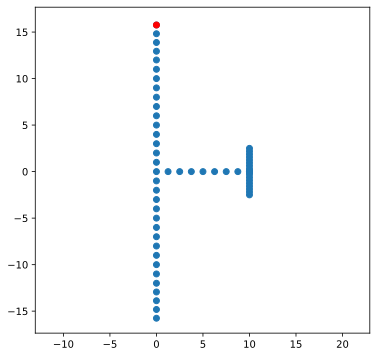

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.scatter(case_data.structure.ini_info.pos[:, 0], case_data.structure.ini_info.pos[:, 1])
ax.axis('equal')
tip_node = np.argmax(case_data.structure.ini_info.pos[:, 1])
print('Wing tip node is the maximum Y one: ', tip_node)
ax.scatter(case_data.structure.ini_info.pos[tip_node, 0], case_data.structure.ini_info.pos[tip_node, 1], color='red')
plt.show()

We can plot now the `pos[tip_node,:]` variable:

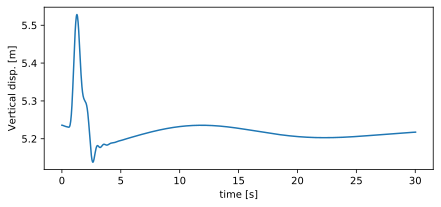

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3))

# extract information
n_tsteps = len(case_data.structure.timestep_info)
xz = np.zeros((n_tsteps, 2))
for it in range(n_tsteps):
    xz[it, 0] = case_data.structure.timestep_info[it].pos[tip_node, 0]
    xz[it, 1] = case_data.structure.timestep_info[it].pos[tip_node, 2]
ax.plot(time_vec, xz[:, 1])
# fig.suptitle('Longitudinal trajectory of the T-Tail model in a 20% 1-cos gust encounter')
ax.set_xlabel('time [s]')
ax.set_ylabel('Vertical disp. [m]');
plt.show()

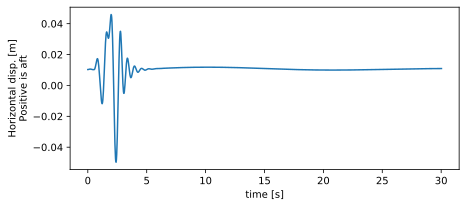

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3))

# extract information
n_tsteps = len(case_data.structure.timestep_info)
xz = np.zeros((n_tsteps, 2))
for it in range(n_tsteps):
    xz[it, 0] = case_data.structure.timestep_info[it].pos[tip_node, 0]
    xz[it, 1] = case_data.structure.timestep_info[it].pos[tip_node, 2]
ax.plot(time_vec, xz[:, 0])
# fig.suptitle('Longitudinal trajectory of the T-Tail model in a 20% 1-cos gust encounter')
ax.set_xlabel('time [s]')
ax.set_ylabel('Horizontal disp. [m]\nPositive is aft');
plt.show()

*Wing root loads*

The wing root loads can be extracted from the `postproc_cell` structure in `timestep_info`.

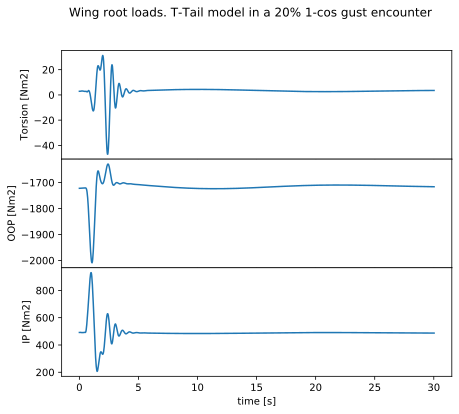

In [22]:
fig, ax = plt.subplots(3, 1, figsize=(7, 6), sharex=True)
ylabels = ['Torsion [Nm2]', 'OOP [Nm2]', 'IP [Nm2]']

# extract information
n_tsteps = len(case_data.structure.timestep_info)
dt = case_data.settings['DynamicCoupled']['dt'].value
time_vec = np.linspace(0, n_tsteps*dt, n_tsteps)
loads = np.zeros((n_tsteps, 3))
for it in range(n_tsteps):
    loads[it, 0:3] = case_data.structure.timestep_info[it].postproc_cell['loads'][0, 3:6]
    
for idim in range(3):
    ax[idim].plot(time_vec, loads[:, idim])
    ax[idim].set_ylabel(ylabels[idim])
    
ax[2].set_xlabel('time [s]')
plt.subplots_adjust(hspace=0)
fig.suptitle('Wing root loads. T-Tail model in a 20% 1-cos gust encounter');
# ax.set_xlabel('X [m]')
# ax.set_ylabel('Z [m]');
plt.show()

## Aerodynamic analysis

The aerodynamic analysis can be obviously conducted using python. However, the easiest way is to run the case by yourself and open the files in `output/simple_HALE/beam` and `output/simple_HALE/aero` with [Paraview](https://www.paraview.org/).

In [23]:
url = 'https://raw.githubusercontent.com/ImperialCollegeLondon/sharpy/dev_doc/docs/source/content/example_notebooks/images/t-tail_solution.png'
Image(url=url, width=600)